In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import *
from numpy import *

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix

from sklearn.model_selection import train_test_split


## Convert series to supervised learning

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [19]:
df = pd.read_csv('../data/use_for_analysis.csv')
# df['start_time'] = df['start_time']//1000
# df = df[df['result'] != 0.5]
# numeric_predictors = ['color', 'diff', 'game_time', 'start_time', 'weekday']
# X = df[numeric_predictors].values
# y = np.array(df['result'])

In [31]:
df = df[['date', 'color', 'day', 'weekday', 'game_time', 'elo', 'diff', 'result']]
df = df[df['result'] != 0.5]

In [32]:
X = df.iloc[:, 0:6].values
y = df.iloc[:, -1].values

In [35]:
X.shape

(2098, 6)

In [38]:
X.shape[0]*.95

1993.1

In [39]:
train_X = X[:1993]
test_X = X[1993:]

train_Y = y[0:1993]
test_Y = y[1993:]

In [46]:
model = Sequential()
model.add(Bidirectional(LSTM(18, return_sequences=True), input_shape=train_X.shape[1:]))
model.add(Bidirectional(LSTM(12, return_sequences=True)))
model.add(Dense(6))
model.compile(loss='mae', optimizer='rmsprop')

ValueError: Input 0 is incompatible with layer bidirectional_4: expected ndim=3, found ndim=2

In [5]:
# # integer encode direction
# encoder = LabelEncoder()
# X = encoder.fit_transform(X)
# # y = encoder.fit_transform(y)

In [7]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [8]:
# # specify the number of lag hours
# n_hours = 3
# n_features = 8

In [9]:
# frame as supervised learning
reframed = series_to_supervised(X, 1, 1)
print(reframed.shape)

(2075, 10)


In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [11]:
# split into input and outputs
# n_obs = n_hours * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(X_train.shape, len(X_train), y_train.shape)

(1660, 5) 1660 (1660,)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1660, 1, 5) (1660,) (416, 1, 5) (416,)


In [13]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [14]:
# fit network
history = model.fit(X_train, y_train, epochs=205, batch_size=12,
                    validation_data=(X_test, y_test), verbose=1, shuffle=False)

Train on 1660 samples, validate on 416 samples
Epoch 1/205
1660/1660 [==============================] - 2s 978us/step - loss: 0.7959 - val_loss: 0.7008
Epoch 2/205
1660/1660 [==============================] - 1s 305us/step - loss: 0.6834 - val_loss: 0.6985
Epoch 3/205
1660/1660 [==============================] - 1s 310us/step - loss: 0.6804 - val_loss: 0.6956
Epoch 4/205
1660/1660 [==============================] - 1s 317us/step - loss: 0.6775 - val_loss: 0.6929
Epoch 5/205
1660/1660 [==============================] - 0s 297us/step - loss: 0.6749 - val_loss: 0.6903
Epoch 6/205
1660/1660 [==============================] - 1s 314us/step - loss: 0.6723 - val_loss: 0.6876
Epoch 7/205
1660/1660 [==============================] - 1s 335us/step - loss: 0.6697 - val_loss: 0.6849
Epoch 8/205
1660/1660 [==============================] - 1s 310us/step - loss: 0.6671 - val_loss: 0.6819
Epoch 9/205
1660/1660 [==============================] - 1s 332us/step - loss: 0.6643 - val_loss: 0.6787
Epoch 10

Epoch 78/205
1660/1660 [==============================] - 0s 292us/step - loss: 0.6148 - val_loss: 0.6631
Epoch 79/205
1660/1660 [==============================] - 1s 338us/step - loss: 0.6160 - val_loss: 0.6626
Epoch 80/205
1660/1660 [==============================] - 1s 318us/step - loss: 0.6145 - val_loss: 0.6626
Epoch 81/205
1660/1660 [==============================] - 1s 331us/step - loss: 0.6154 - val_loss: 0.6620
Epoch 82/205
1660/1660 [==============================] - 1s 323us/step - loss: 0.6142 - val_loss: 0.6621
Epoch 83/205
1660/1660 [==============================] - 1s 324us/step - loss: 0.6148 - val_loss: 0.6615
Epoch 84/205
1660/1660 [==============================] - 1s 335us/step - loss: 0.6140 - val_loss: 0.6616
Epoch 85/205
1660/1660 [==============================] - 1s 335us/step - loss: 0.6141 - val_loss: 0.6609
Epoch 86/205
1660/1660 [==============================] - 1s 317us/step - loss: 0.6139 - val_loss: 0.6611
Epoch 87/205
1660/1660 [======================

Epoch 155/205
1660/1660 [==============================] - 1s 303us/step - loss: 0.5976 - val_loss: 0.6429
Epoch 156/205
1660/1660 [==============================] - 1s 305us/step - loss: 0.5986 - val_loss: 0.6433
Epoch 157/205
1660/1660 [==============================] - 1s 302us/step - loss: 0.5971 - val_loss: 0.6425
Epoch 158/205
1660/1660 [==============================] - 1s 311us/step - loss: 0.5981 - val_loss: 0.6429
Epoch 159/205
1660/1660 [==============================] - 1s 318us/step - loss: 0.5966 - val_loss: 0.6422
Epoch 160/205
1660/1660 [==============================] - 1s 313us/step - loss: 0.5976 - val_loss: 0.6426
Epoch 161/205
1660/1660 [==============================] - 1s 319us/step - loss: 0.5962 - val_loss: 0.6419
Epoch 162/205
1660/1660 [==============================] - 1s 307us/step - loss: 0.5971 - val_loss: 0.6423
Epoch 163/205
1660/1660 [==============================] - 1s 306us/step - loss: 0.5958 - val_loss: 0.6417
Epoch 164/205
1660/1660 [============

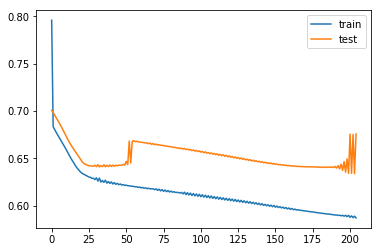

In [15]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [17]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [18]:
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [19]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.466


In [24]:
confusion_matrix(y_test, yhat)

ValueError: Classification metrics can't handle a mix of binary and continuous targets